# Tempo estimation and beat tracking  

### George Tzanetakis, University of Victoria 

In this notebook we will explore the basic concepts behind tempo estimation and beat tracking. 


In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.interpolate import interp1d 

import IPython.display as ipd

Let's also load an audio recording

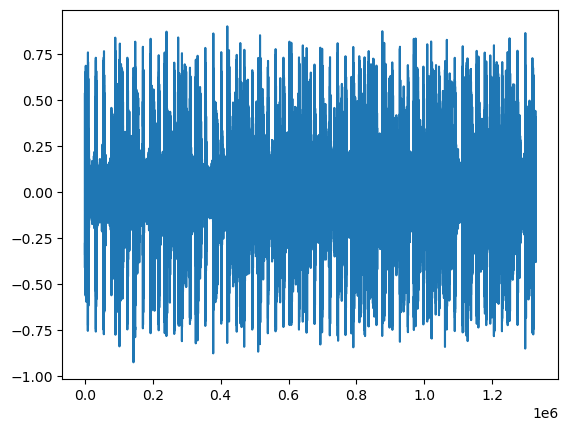

In [2]:
import scipy.io.wavfile as wav
srate, audio_signal = wav.read("disco.00000.wav")
# scale to -1.0/1.0 
audio = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
audio= (0.9 / max(audio)) * audio

plt.figure() 
plt.plot(audio)
ipd.Audio(audio,rate=srate)


Now that we have seen how we can estimate the pitch of a single frame of audio 
we can abstract this process into functions and then write a function that 
given an audio signal returns the associated pitch track and amplitude track (RMS) 
using a particular pitch extraction method. 

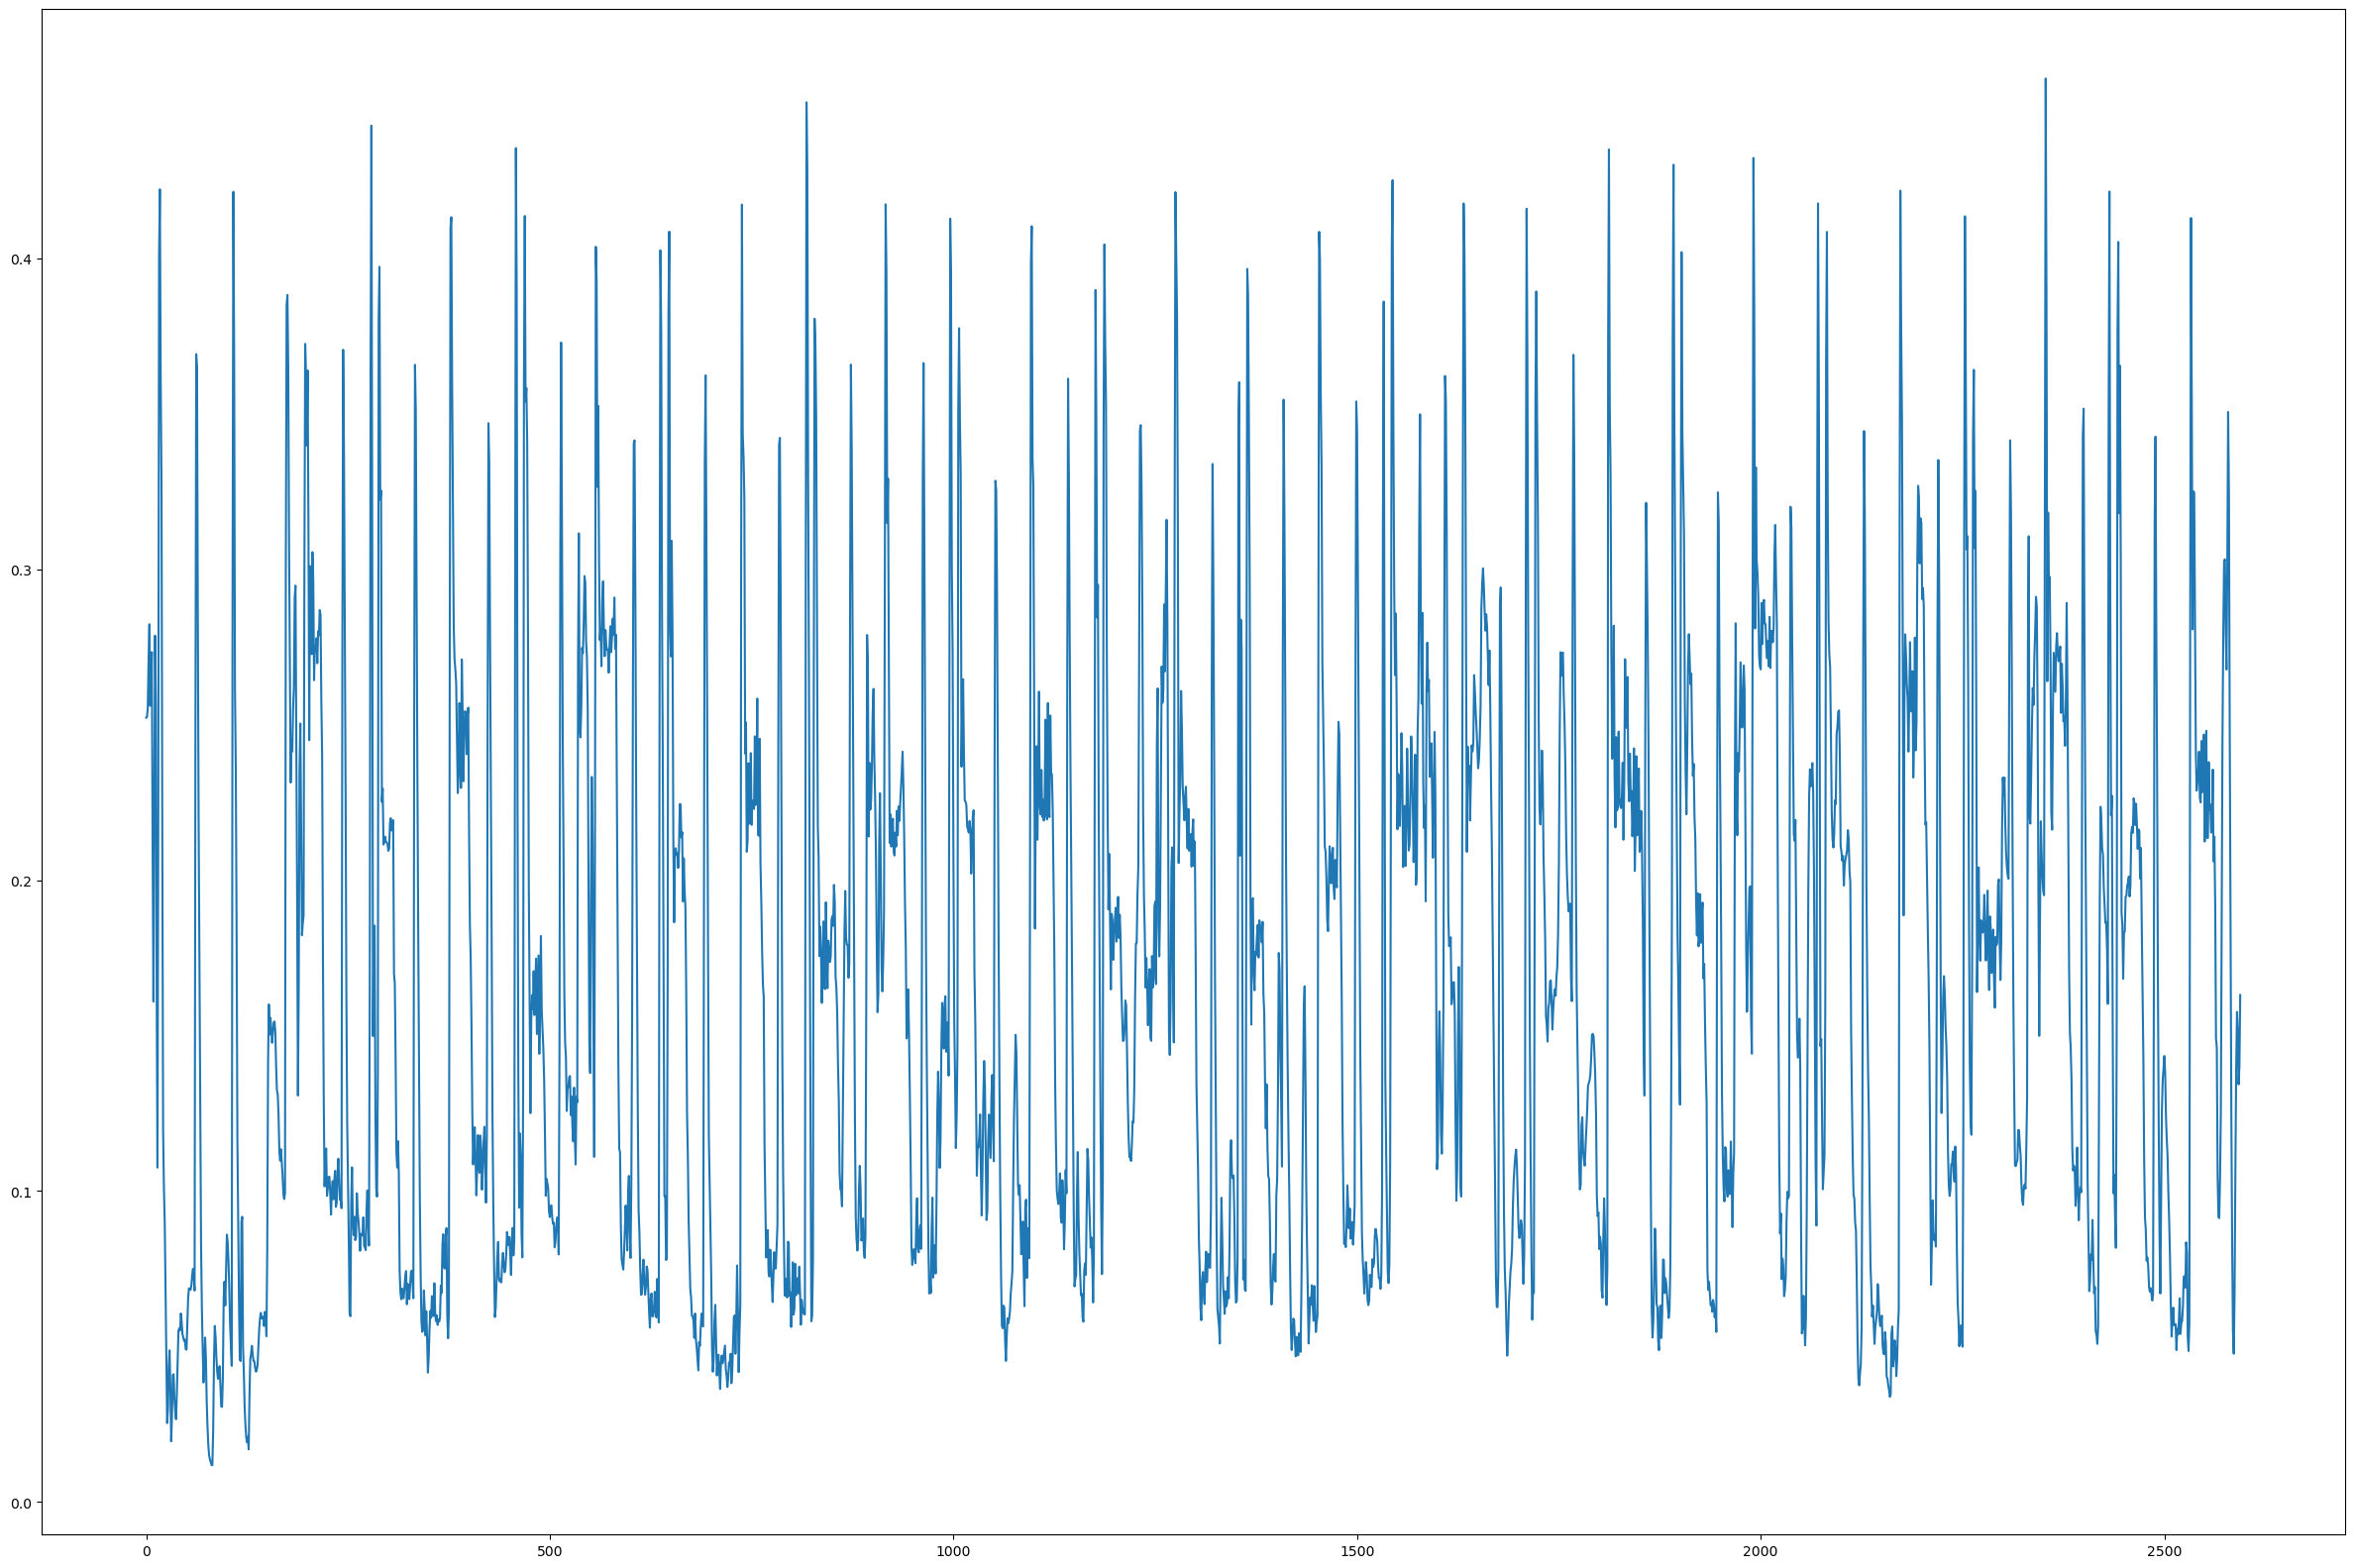

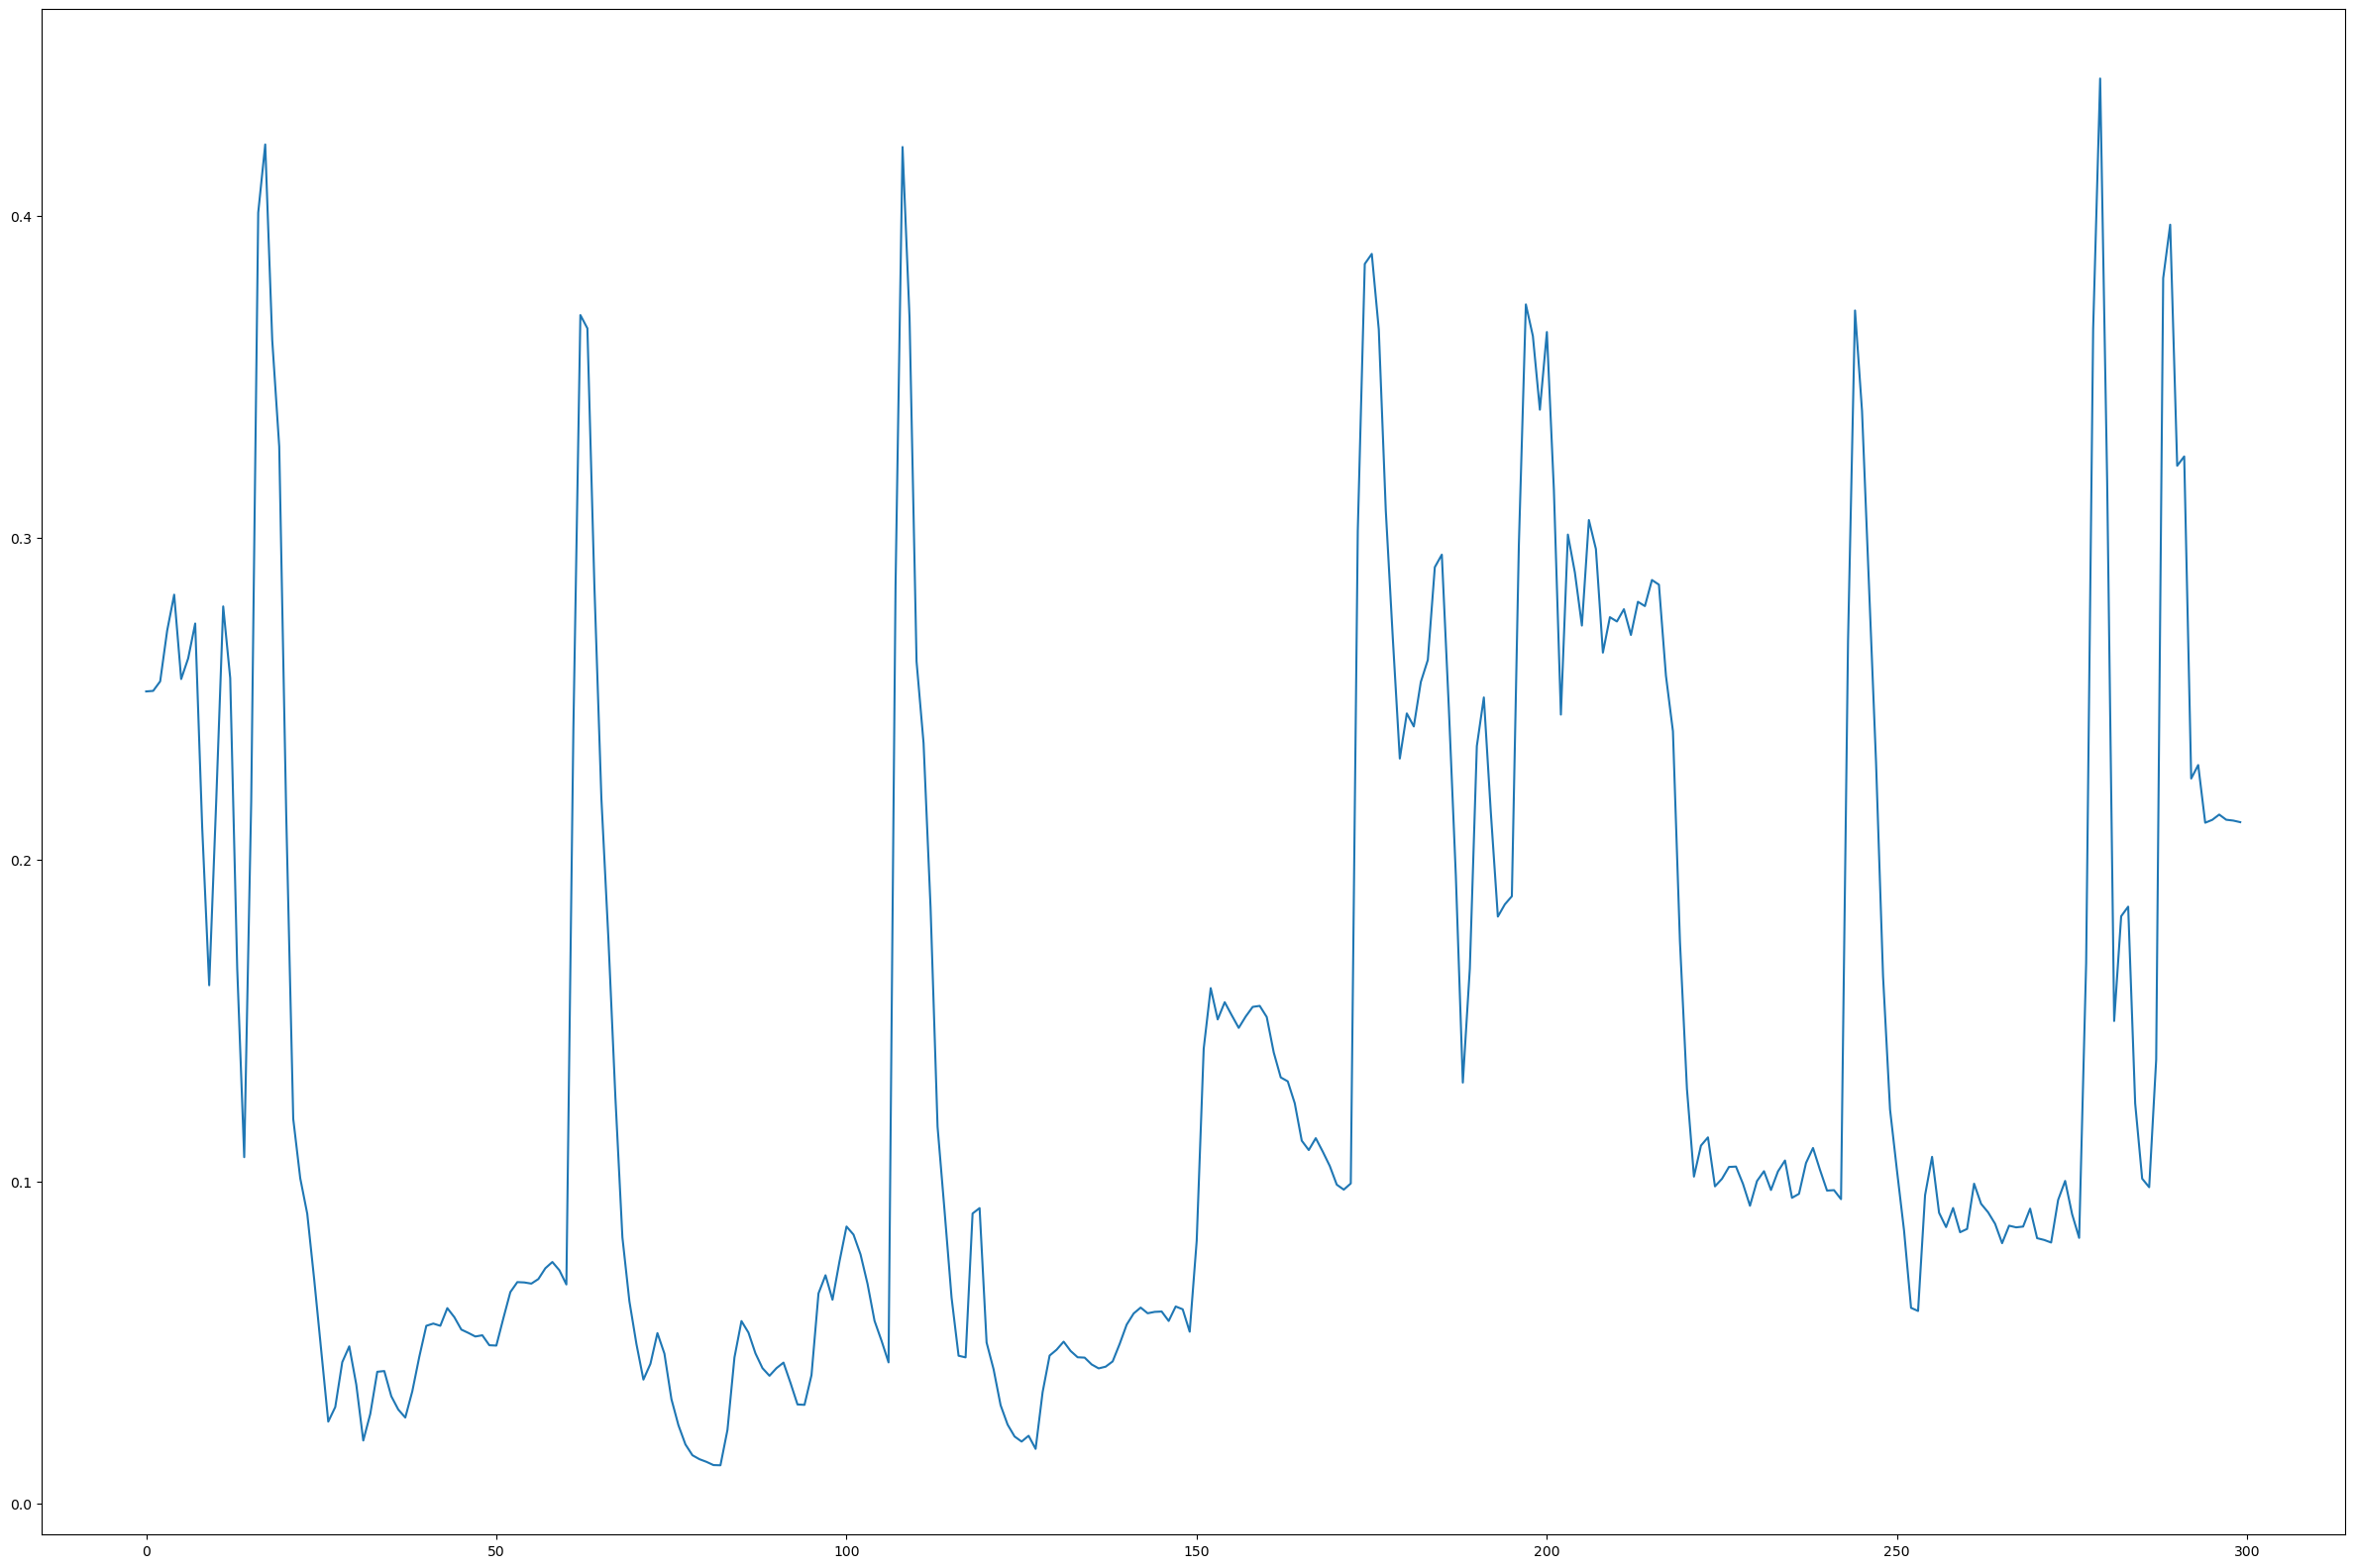

In [12]:

def rms_track(data, hopSize, winSize): 
    offsets = np.arange(0, len(data), hopSize)
    rms_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = data[o:o+winSize] 
        rms_track[m] = np.sqrt(np.mean(np.square(frame)))  
    return (rms_track)
    
# compute the pitch track 
hopSize = 512 
winSize = 1024
pt = rms_track(audio, hopSize, winSize)

plt.figure(figsize=(30,20)) 
plt.plot(pt)
plt.figure(figsize=(30,20))
plt.plot(pt[:300])

    

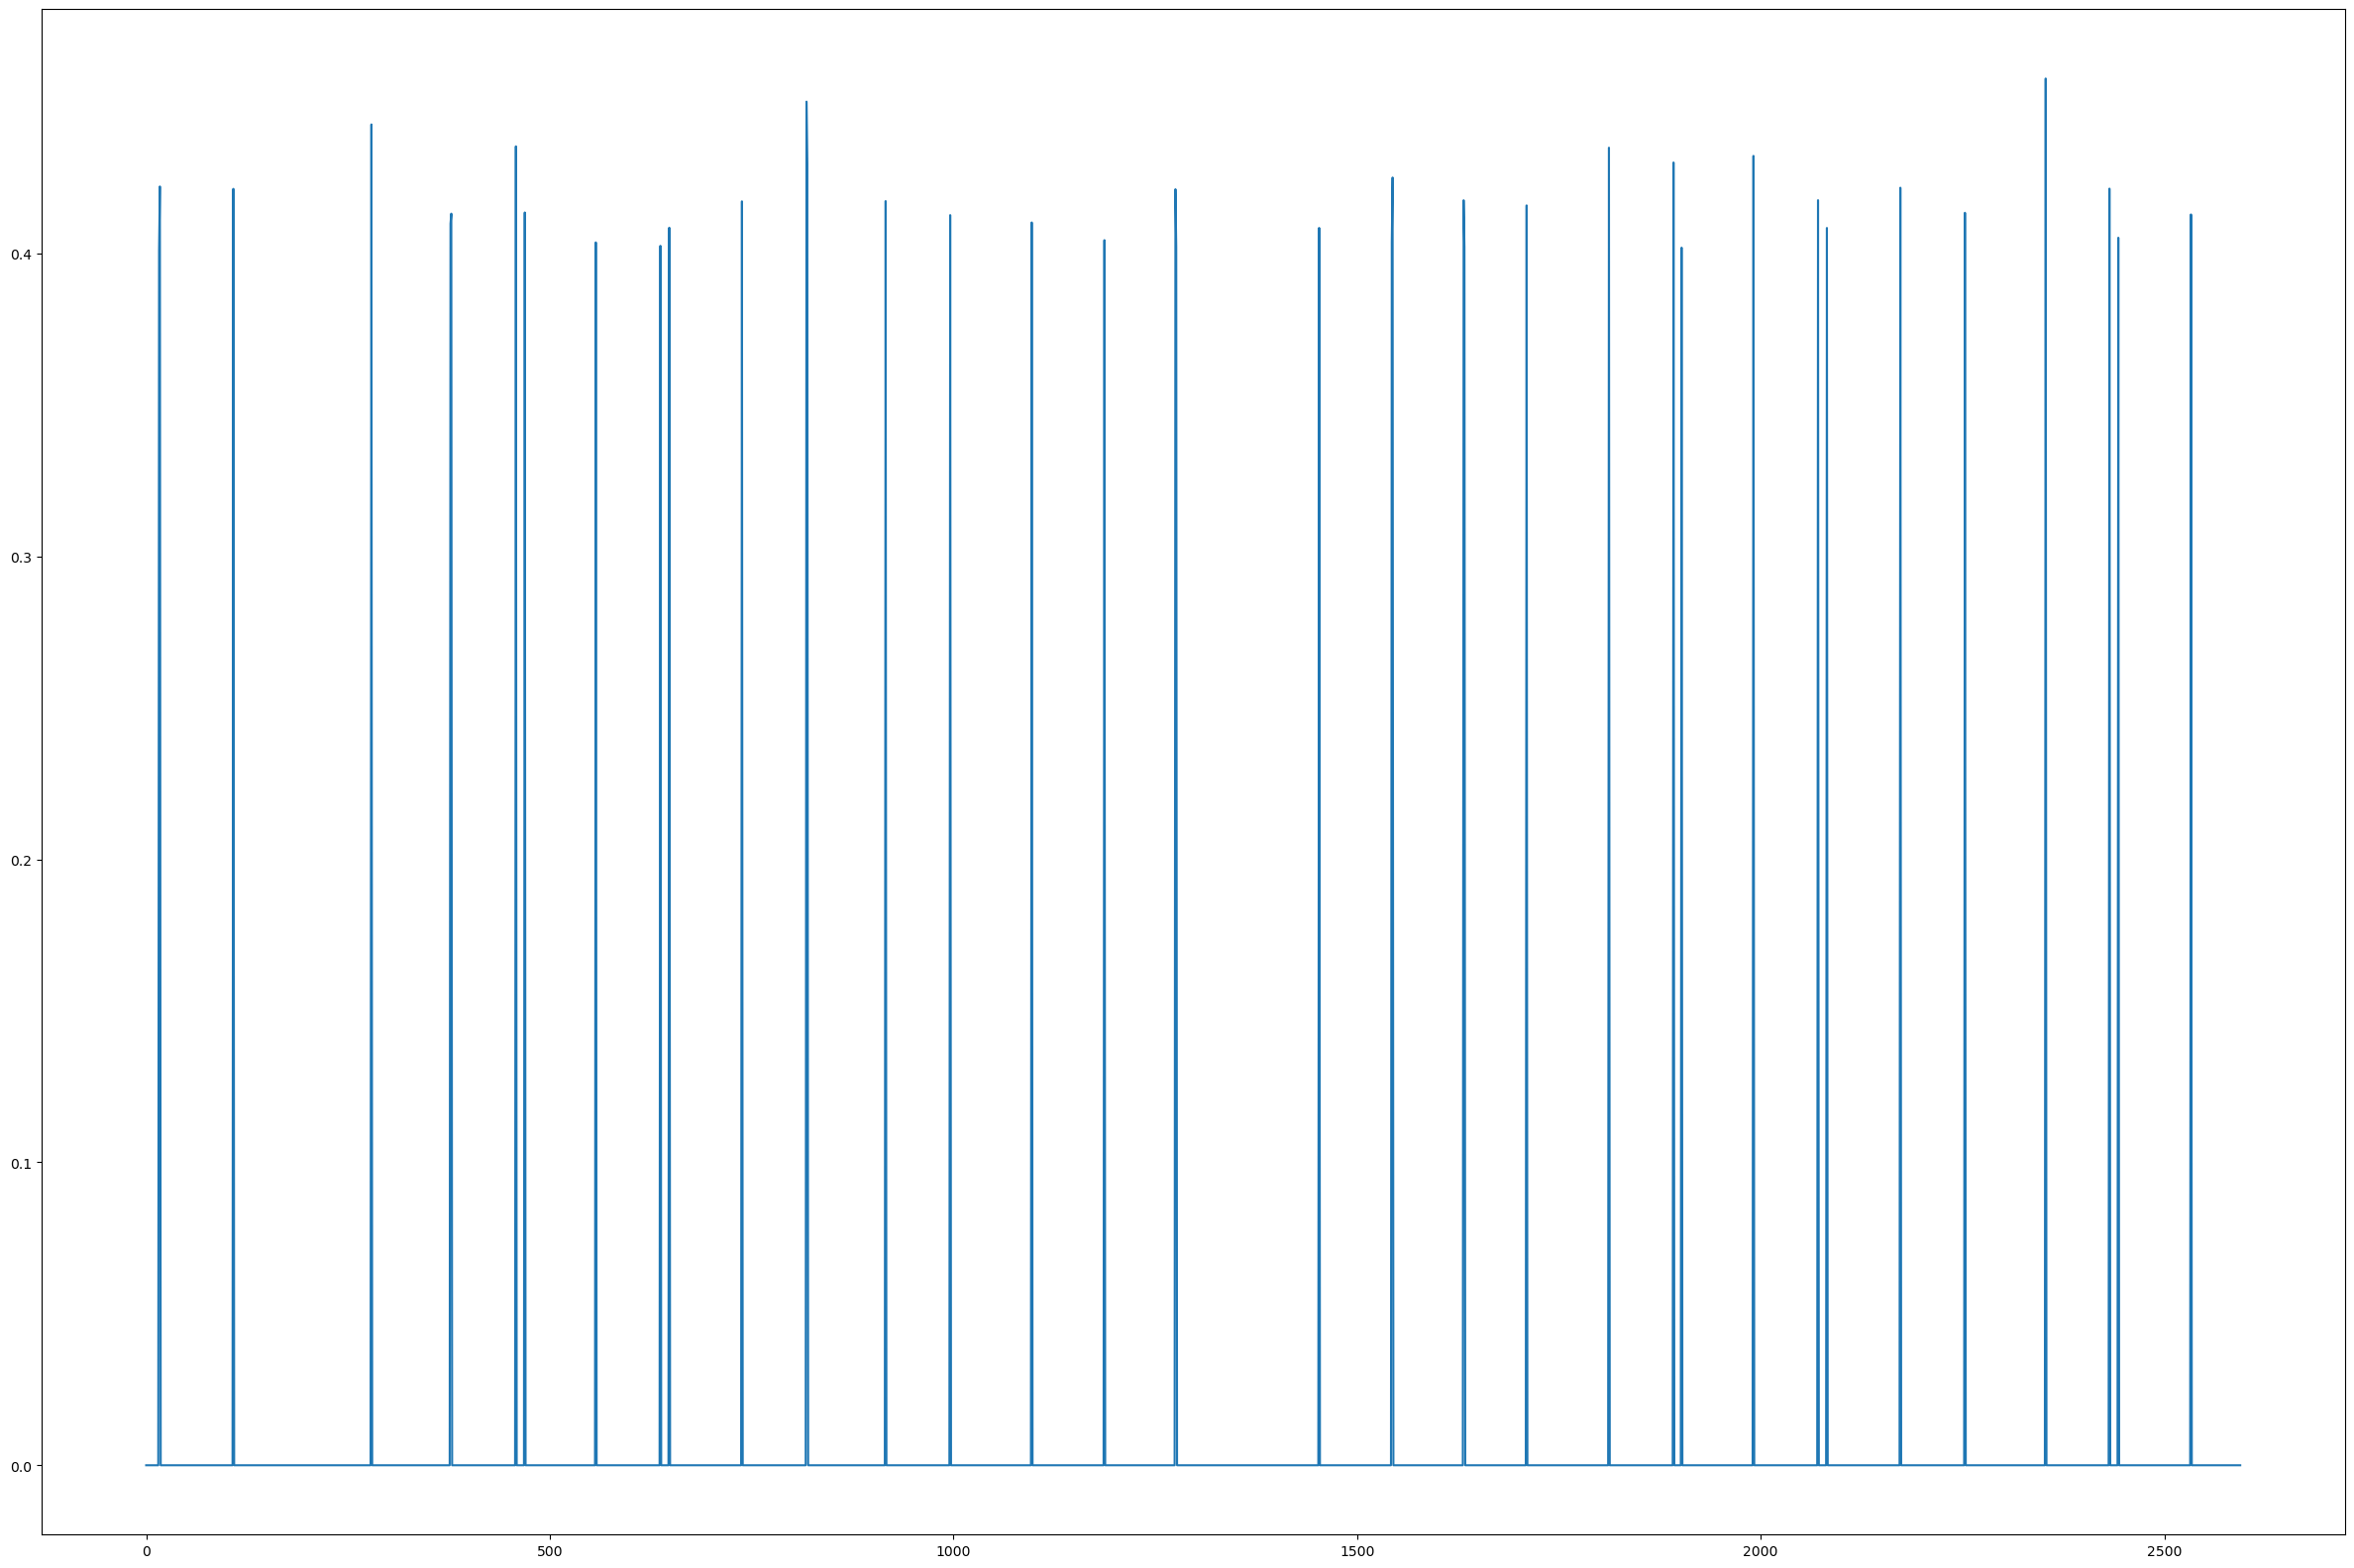

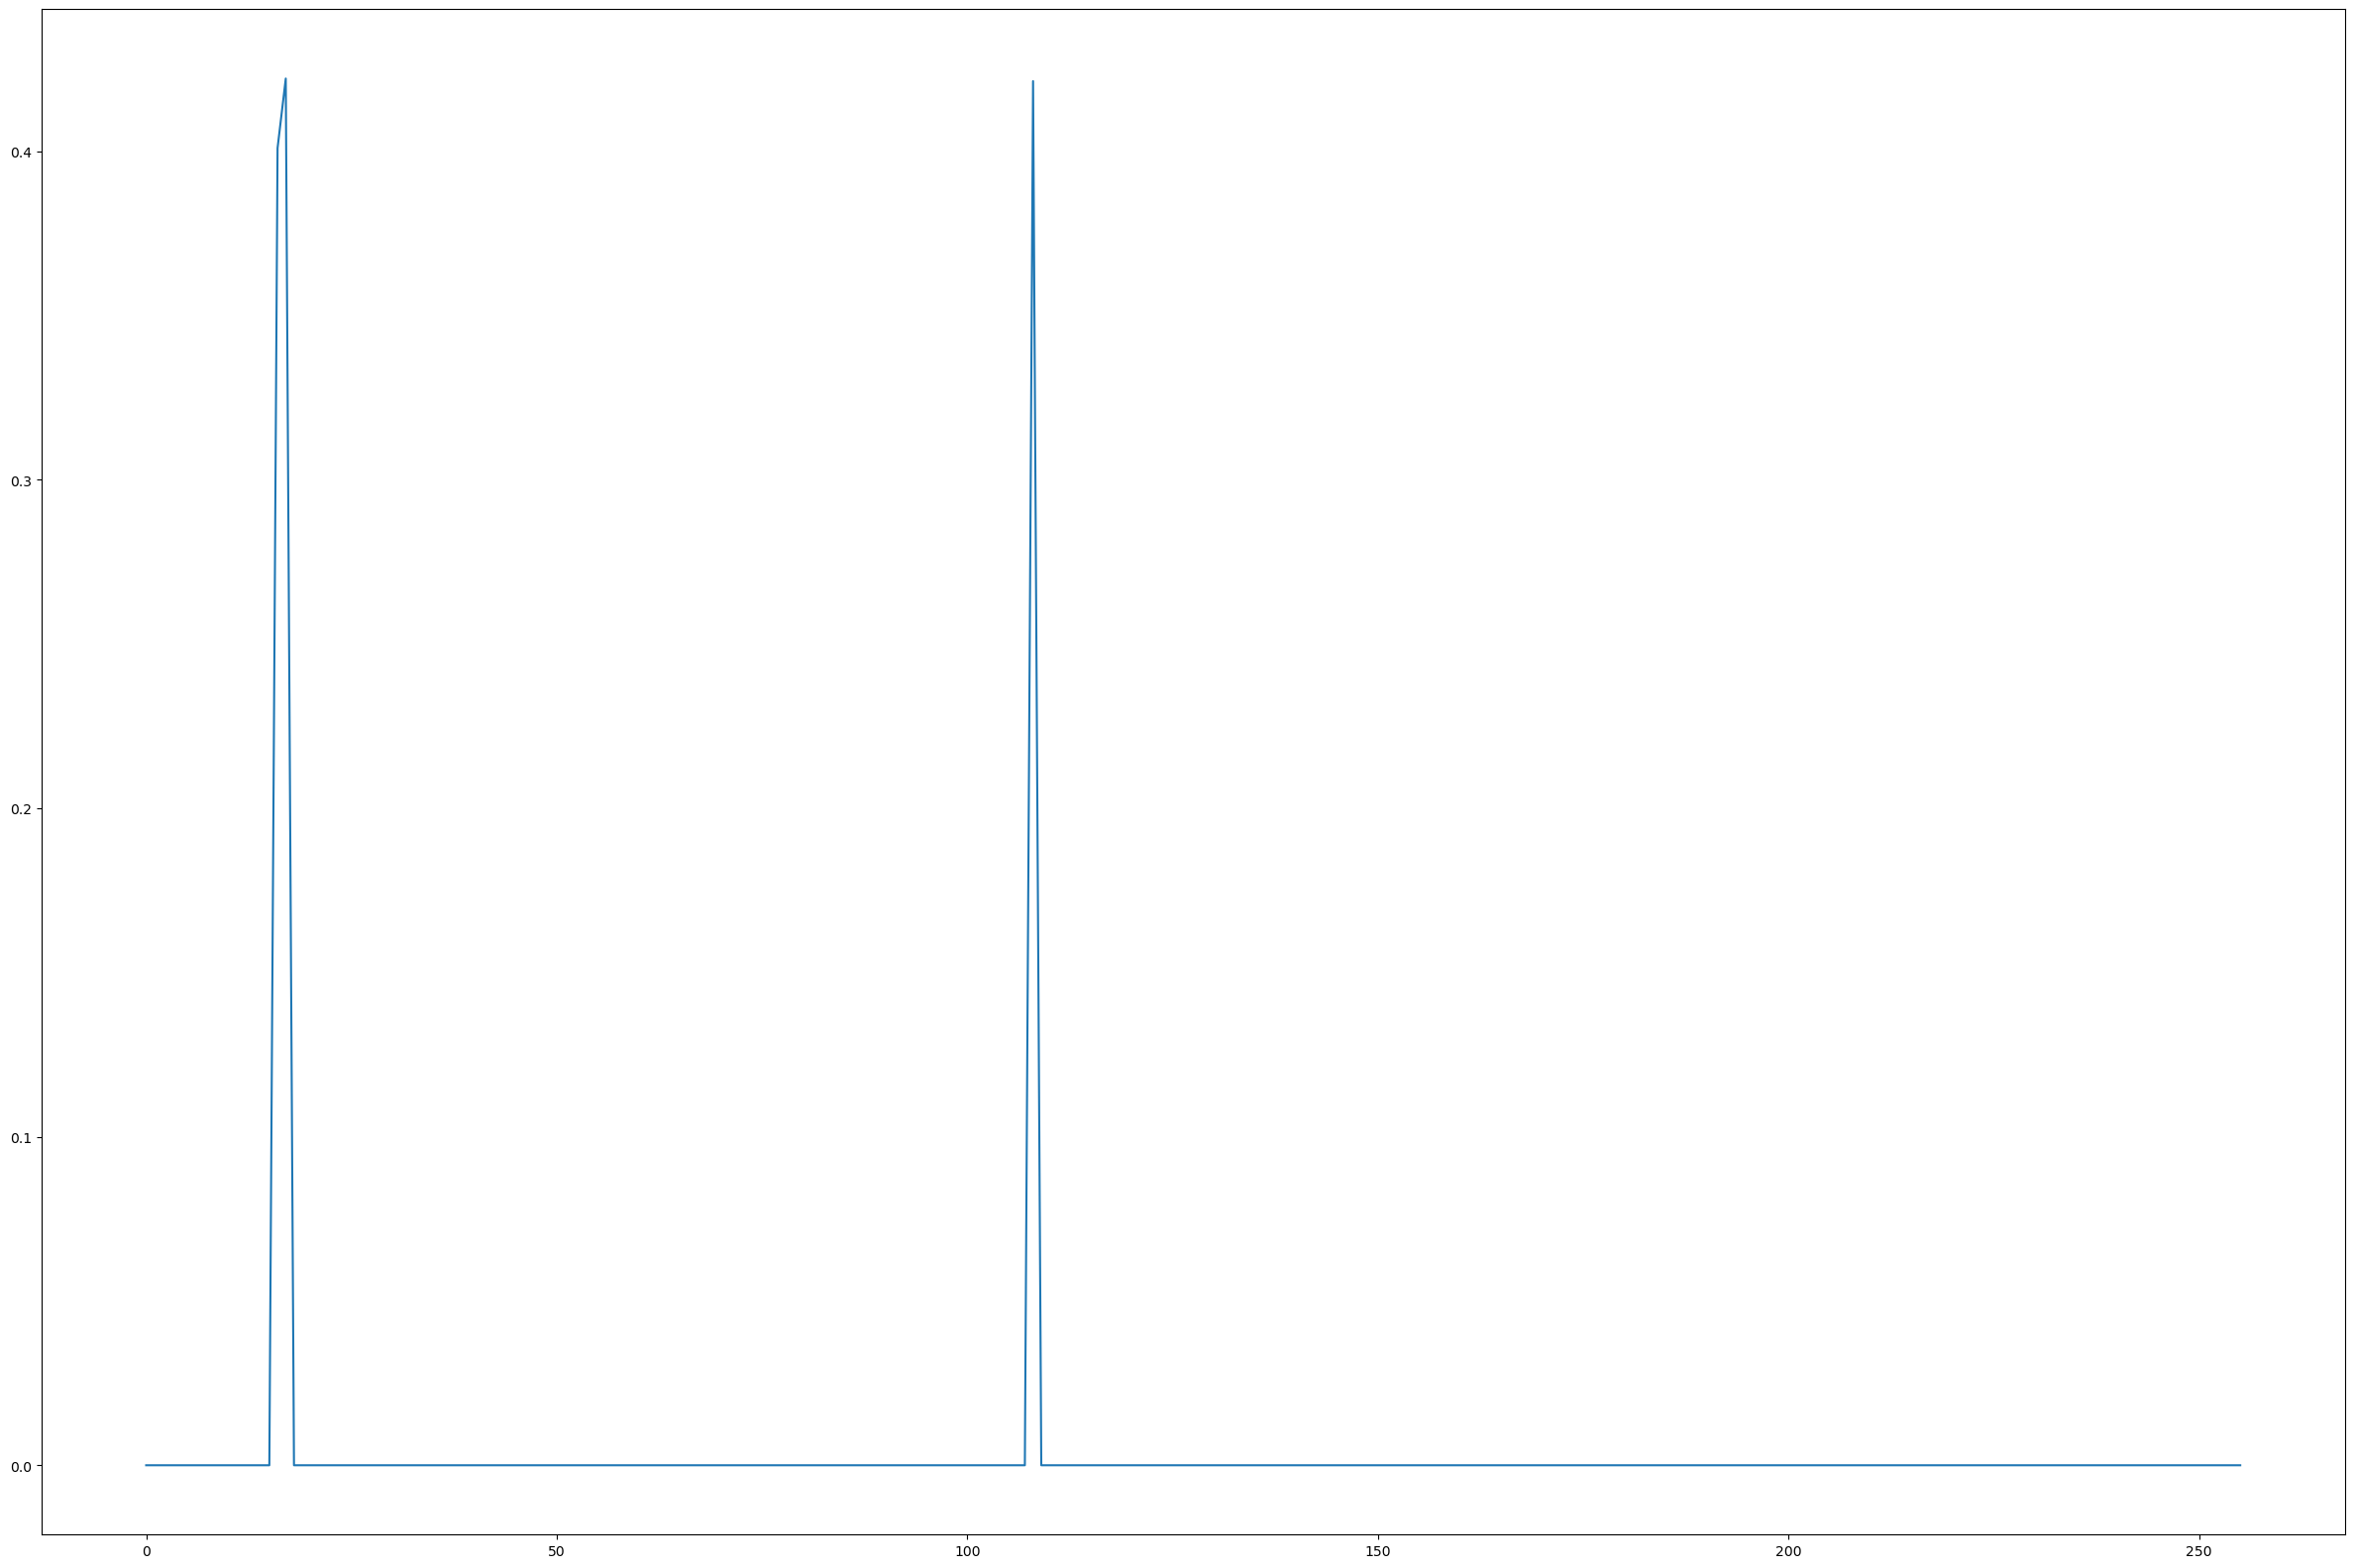

In [13]:
peaks = np.where(pt<0.4, 0, pt)
plt.figure(figsize=(30,20)) 
plt.plot(peaks)
plt.figure(figsize=(30,20))
plt.plot(peaks[:256])

In [14]:
indices = np.nonzero(peaks)[0]
print(np.diff(indices))

[  1  91 171  98   1  80  11  88  80  11  90  80   1  97  80 101  90  88
   1 177  90   1  88   1  77 102  80  10  89  80  11  91  80 100  79  11
  90]


In [15]:
period_in_frames = np.median(np.diff(indices))
print(period_in_frames)
period_in_samples = period_in_frames * hopSize
print(period_in_samples)

80.0
40960.0


In [16]:
period_in_secs = period_in_samples / srate
print(period_in_samples / srate)

0.9287981859410431


In [17]:
bpm = 60.0 / period_in_secs 
print("Tempo estimate (BPM): %2.2f" %  bpm)

Tempo estimate (BPM): 64.60


In [18]:
# noise burst 
noise = np.random.normal(0, 1.0, winSize)
noise *= np.hanning(winSize)


def sonify_onsets(audio, hopSize, indices): 
    # output signal 
    osignal = np.zeros(len(audio))
    k = 1 

    offsets = np.arange(0, len(audio), hopSize)
    for (m,o) in enumerate(offsets): 
        iframe = audio[o:o+winSize] 
        oframe = 0.4 * iframe 


        # replace frame with noise if the frame corresponds to an onset  
        if ((k < len(indices)) and (m == indices[k:][0])): 
            k += 1
            osignal[o:o+winSize] += noise
        else: 
            osignal[o:o+winSize] += oframe 
    return osignal 

osignal = sonify_onsets(audio, hopSize, indices)
ipd.Audio(osignal,rate=srate)

In [10]:
tempo_onset = indices[1]
tempo_indices = [tempo_onset] 
while tempo_onset * hopSize < len(audio): 
    tempo_onset = tempo_onset + period_in_frames
    tempo_indices.append(tempo_onset)
print(tempo_indices)

osignal = sonify_onsets(audio, hopSize, tempo_indices)
ipd.Audio(osignal,rate=srate)

[34, 37.0, 40.0, 43.0, 46.0, 49.0, 52.0, 55.0, 58.0, 61.0, 64.0, 67.0, 70.0, 73.0, 76.0, 79.0, 82.0, 85.0, 88.0, 91.0, 94.0, 97.0, 100.0, 103.0, 106.0, 109.0, 112.0, 115.0, 118.0, 121.0, 124.0, 127.0, 130.0, 133.0, 136.0, 139.0, 142.0, 145.0, 148.0, 151.0, 154.0, 157.0, 160.0, 163.0, 166.0, 169.0, 172.0, 175.0, 178.0, 181.0, 184.0, 187.0, 190.0, 193.0, 196.0, 199.0, 202.0, 205.0, 208.0, 211.0, 214.0, 217.0, 220.0, 223.0, 226.0, 229.0, 232.0, 235.0, 238.0, 241.0, 244.0, 247.0, 250.0, 253.0, 256.0, 259.0, 262.0, 265.0, 268.0, 271.0, 274.0, 277.0, 280.0, 283.0, 286.0, 289.0, 292.0, 295.0, 298.0, 301.0, 304.0, 307.0, 310.0, 313.0, 316.0, 319.0, 322.0, 325.0, 328.0, 331.0, 334.0, 337.0, 340.0, 343.0, 346.0, 349.0, 352.0, 355.0, 358.0, 361.0, 364.0, 367.0, 370.0, 373.0, 376.0, 379.0, 382.0, 385.0, 388.0, 391.0, 394.0, 397.0, 400.0, 403.0, 406.0, 409.0, 412.0, 415.0, 418.0, 421.0, 424.0, 427.0, 430.0, 433.0, 436.0, 439.0, 442.0, 445.0, 448.0, 451.0, 454.0, 457.0, 460.0, 463.0, 466.0, 469.0, 4

ValueError: operands could not be broadcast together with shapes (232,) (512,) (232,) 

91
Tempo estimate (BPM): 56.79


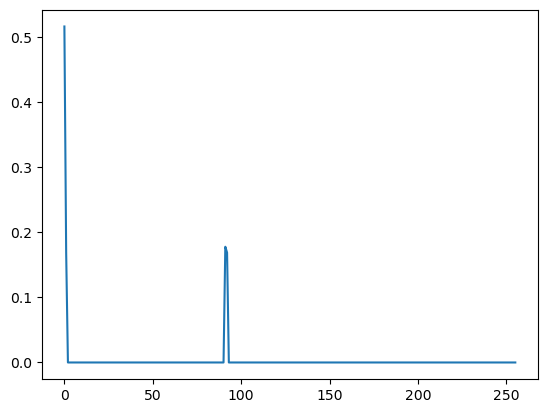

In [19]:
peaks = peaks[:256]
acr = np.correlate(peaks, peaks, mode='full')
acr = acr[int(len(acr)/2):]
plt.plot(acr)
acr_peak_location = np.argmax(acr[1:])+1
print(acr_peak_location)
bpm = 60.0 * (float(srate) / (acr_peak_location * hopSize))
print("Tempo estimate (BPM): %2.2f" %  bpm)


In [20]:
tempo_indices[0::4]

[34,
 46.0,
 58.0,
 70.0,
 82.0,
 94.0,
 106.0,
 118.0,
 130.0,
 142.0,
 154.0,
 166.0,
 178.0,
 190.0,
 202.0,
 214.0,
 226.0,
 238.0,
 250.0,
 262.0,
 274.0,
 286.0,
 298.0,
 310.0,
 322.0,
 334.0,
 346.0,
 358.0,
 370.0,
 382.0,
 394.0,
 406.0,
 418.0,
 430.0,
 442.0,
 454.0,
 466.0,
 478.0,
 490.0,
 502.0,
 514.0,
 526.0,
 538.0,
 550.0,
 562.0,
 574.0,
 586.0,
 598.0,
 610.0,
 622.0,
 634.0,
 646.0,
 658.0,
 670.0,
 682.0,
 694.0,
 706.0,
 718.0,
 730.0,
 742.0,
 754.0,
 766.0,
 778.0,
 790.0,
 802.0,
 814.0,
 826.0,
 838.0,
 850.0,
 862.0,
 874.0,
 886.0,
 898.0,
 910.0,
 922.0,
 934.0,
 946.0,
 958.0,
 970.0,
 982.0,
 994.0,
 1006.0,
 1018.0,
 1030.0,
 1042.0,
 1054.0,
 1066.0,
 1078.0,
 1090.0,
 1102.0,
 1114.0,
 1126.0,
 1138.0,
 1150.0,
 1162.0,
 1174.0,
 1186.0,
 1198.0,
 1210.0,
 1222.0,
 1234.0,
 1246.0,
 1258.0,
 1270.0,
 1282.0,
 1294.0,
 1306.0,
 1318.0,
 1330.0,
 1342.0,
 1354.0,
 1366.0,
 1378.0,
 1390.0,
 1402.0,
 1414.0,
 1426.0,
 1438.0,
 1450.0,
 1462.0,
 1474.0,


In [21]:
nbeats = 8 

avg_bar = np.zeros(44 * nbeats * hopSize)
print("Avg bar shape:", avg_bar.shape)
for (n,t) in enumerate(tempo_indices[0::nbeats]): 
    bar = audio[int(t) * hopSize: int(t)* hopSize + 44 * nbeats * hopSize]
    if (n < len(tempo_indices[0::nbeats])-1):
        if (avg_bar.shape == bar.shape):
            avg_bar += bar
ipd.Audio(avg_bar,rate=srate)

Avg bar shape: (180224,)
